# 💻 Punkt-i-polygon analyse

Å finne ut om et bestemt punkt er plassert innenfor eller utenfor et område,
eller å finne ut om en linje krysser en annen linje eller polygon er
grunnleggende romlige spørringer som ofte brukes f.eks. for å velge
data basert på plassering. Slike romlige spørringer er en av de typiske
første trinnene i arbeidsflyten når du gjør romlig analyse. Å utføre en
romlig kobling (vil bli introdusert senere) mellom to romlige datasett er
en av de mest typiske bruksområdene der Punkt-i-Polygon (PIP)-analyser
brukes.

For videre lesing om PIP og andre geometriske operasjoner,
se kapittel 4.2 i Smith, Goodchild & Longley: [Geospatial Analysis - 6th edition](https://www.spatialanalysisonline.com/HTML/index.html).


## Hvordan sjekke om et punkt er inne i en polygon?

Beregningsteknisk er det mest vanlig å oppdage om et punkt er inne i en polygon ved å bruke en spesifikk formel kalt [Ray Casting-algoritmen](https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm).
Heldigvis trenger vi ikke å lage en slik funksjon selv for
utføre Punkt-i-Polygon (PIP)-analyser. I stedet kan vi dra
fordel av [Shapely's binære predikater](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates)
som kan evaluere de topologiske forholdene mellom geografiske
objekter, så som PIP, som vi er interessert i her.

## Spørringer om punkt-i-polygon på `shapely` geometrier

Det er stort sett to måter å utføre PIP på i Shapely:

1. ved hjelp av en funksjon kalt
   [within()](https://shapely.readthedocs.io/en/stable/manual.html#object.within)
   som sjekker om et punkt er innenfor et polygon
2. ved hjelp av en funksjon kalt
   [contains()](https://shapely.readthedocs.io/en/stable/manual.html#object.contains)
   som sjekker om et polygon inneholder et punkt

:::{note}
Selv om vi snakker her om **Point** i Polygon
operasjon, er det også mulig å sjekke om en LineString eller Polygon er
inne i et annen Polygon.
:::


La oss først lage et par punktgeometrier:

In [1]:
import shapely.geometry
punkt1 = shapely.geometry.Point(24.952242, 60.1696017)
punkt2 = shapely.geometry.Point(24.976567, 60.1612500)

... og en polygon:

In [2]:
polygon = shapely.geometry.Polygon(
    [
        (24.950899, 60.169158),
        (24.953492, 60.169158),
        (24.953510, 60.170104),
        (24.950958, 60.169990)
    ]
)

In [3]:
print(punkt1)
print(punkt2)
print(polygon)

POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


La oss sjekke om punktene er `within()` polygonet:

In [4]:
punkt1.within(polygon)

True

In [5]:
punkt2.within(polygon)

False

Det ser ut til at det første punktet er inne i polygonet, men det andre er ikke det.

Vi kan snu logikken til spørringen: I stedet for å sjekke om punktet er
innenfor polygonet, kan vi også spørre om polygonet `contains()` punktet:

In [6]:
polygon.contains(punkt1)

True

In [7]:
polygon.contains(punkt2)

False

:::{hint}
De to måtene å sjekke det romlige forholdet er komplementære og gir
ekvivalente resultater;
[`contains()`](https://shapely.readthedocs.io/en/stable/manual.html#object.contains)
er invers av
[`within()`](https://shapely.readthedocs.io/en/stable/manual.html#object.within),
og omvendt.

Så, hvilken skal du bruke? Vel, det avhenger av:

-  hvis du har **mange punkter og bare ett polygon** og du prøver å finne ut
   hvilket av dem som er inne i polygonet: Da må du kanskje iterere over punktene
   og sjekke ett om gangen om det er **`within()`** polygonet.
-  hvis du har **mange polygoner og bare ett punkt** og du vil finne ut
   hvilket polygon som inneholder punktet: Da må du kanskje iterere over polygonene
   til du finner et polygon som **`contains()`** det spesifiserte punktet
:::


## Spørringer om punkt-i-polygon på `geopandas.GeoDataFrame`s

I det følgende praktiske eksempelet finner vi ut hvilke av adressene vi fikk
i [geokodingseksjonen](geokoding_i_geopandas) som ligger innenfor en bestemt
bydel i Oslo.


In [8]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

In [10]:
import geopandas

bydeler = geopandas.read_file(
    DATA_MAPPE / "oslo_bydeler" / "oslo_bydeler.gpkg"
)
bydeler.head()

,bydelsnr,bynavn,bydel,geometry
0,030101,Oslo,Gamle Oslo,"MULTIPOLYGON (((10.66087 59.88365, 10.66472 59..."
1,030102,Oslo,Grünerløkka,"MULTIPOLYGON (((10.75378 59.91469, 10.75453 59..."
2,030103,Oslo,Sagene,"MULTIPOLYGON (((10.77156 59.93095, 10.77135 59..."
3,030104,Oslo,St.Hanshaugen,"MULTIPOLYGON (((10.75136 59.91923, 10.75158 59..."
4,030105,Oslo,Frogner,"MULTIPOLYGON (((10.65562 59.89038, 10.65381 59..."


<Axes: >

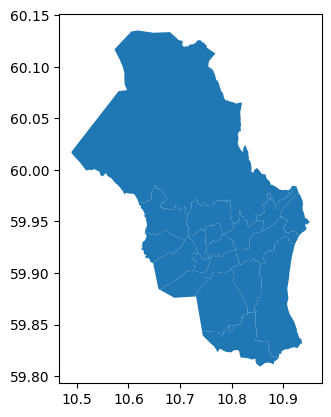

In [11]:
bydeler.plot()

Spesielt ønsker vi å finne ut hvilke punkter som er innenfor bydelen "Gamle Oslo". La oss begynne med å få et separat datasett for
denne bydele, laste in adressene, og plotte et flerlagskart
som viser alle bydelene, "Gamle Oslo" og alle punktene i
ett kart:

In [12]:
gamle_oslo = bydeler[bydeler.bydel == "Gamle Oslo"]
gamle_oslo

,bydelsnr,bynavn,bydel,geometry
0,030101,Oslo,Gamle Oslo,"MULTIPOLYGON (((10.66087 59.88365, 10.66472 59..."


In [13]:
adresser = geopandas.read_file(DATA_MAPPE / "oslo_adresser" / "adresser.gpkg")

:::{admonition} Plotting av flere kartlag
:class: hint

For å plotte flere kartlag i én figur, bruk `ax` parameteren for å spesifisere i
hvilke *akser* data skal plottes. 

Den enkleste måten å få en *akse* er å lagre den første `plot()`ens
returverdi (se nedenfor). Et annet alternativ er å lage [`subplots()`](https://geo-python-site.readthedocs.io/en/latest/notebooks/L7/advanced-plotting.html#using-subplots), muligens med bare en rad og en kolonne.
:::

<Axes: >

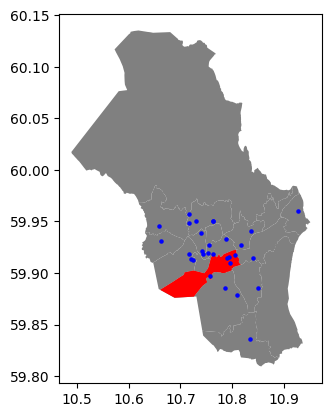

In [14]:
akser = bydeler.plot(facecolor="grey")
gamle_oslo.plot(ax=akser, facecolor="red")
adresser.plot(ax=akser, color="blue", markersize=5)

Noen punkter er innenfor 'Gamle Oslo', men andre er det ikke. For å finne
ut hvilke som er de inne i bydelen, kan vi bruke en **punkt-i-polygon
spørring**, denne gangen på en hel `geopandas.GeoDataFrame`. Metoden
`within()` returnerer boolske (`True`/`False`) verdier som indikerer om eller ikke
en rads geometri er inni den angitte *andre* geometrien:


:::{admonition} geometri vs. geometrikolonne
:class: caution

I eksempelet nedenfor bruker vi `gamle_oslo.at[0, "geometry"]` for å få en enkelt
verdi, et `shapely.geometry.Polygon`, i stedet for en hel kolonne (en
`GeoSeries`). Dette er for å matche hver rad's geometri av hele
`adresser`-dataframen mot *det samme polygonet*. Hvis, i motsetning, vi ville
kjøre `within()` mot en kolonne, ville operasjonen bli utført radvis,
dvs. det første adressepunktet ville bli sjekket mot det første polygonet, det
andre adressepunktet mot det andre polygonet, og så videre.

Sjekk [dokumentasjonen for
`within()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.within.html)
for å lære mer!
:::

In [15]:
adresser.within(gamle_oslo.at[0, "geometry"])

0     False
1     False
2     False
3     False
4     False
5     False
6      True
7     False
8      True
9     False
10    False
11     True
12    False
13    False
14     True
15     True
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27     True
28    False
29    False
dtype: bool

Denne listen med boolske verdier, også kalt en *maske-array* kan brukes til å filtrere
input dataframen:

In [16]:
adresser_i_gamle_oslo = adresser[
    adresser.within(gamle_oslo.at[0, "geometry"])
]
adresser_i_gamle_oslo

,address,id,adr,geometry
6,"5, Etterstadsletta, Gamle Oslo, Oslo, 0660, Norge",106,"Etterstadsletta 5, 0660 OSLO",POINT (10.79645 59.90968)
8,"21, Fyrstikkalléen, Lilleberg, Gamle Oslo, Osl...",108,"Fyrstikkalleen 21, 0661 OSLO",POINT (10.79433 59.91526)
11,"20B, Herslebs gate, Grønland, Gamle Oslo, Oslo...",111,"Herslebs gate 20B, 0561 OSLO",POINT (10.76403 59.91813)
14,"30, Kongsveien, Grønlia, Gamle Oslo, Oslo, 019...",114,"Kongsveien 30, 0193 OSLO",POINT (10.75825 59.89739)
15,"Gladengveien 3B, Gladengveien, Ensjø, Gamle Os...",115,"Gladengveien 3B, 0661 OSLO",POINT (10.79030 59.91467)
27,"16H, Innspurten, Gullhaug, Gamle Oslo, Oslo, 0...",127,"Innspurten 16, 0663 OSLO",POINT (10.80533 59.91732)


Til slutt, la oss plotte denne listen med adresser en gang til for visuelt å verifisere
at alle av dem, faktisk, er plassert i 'Gamle Oslo':

<Axes: >

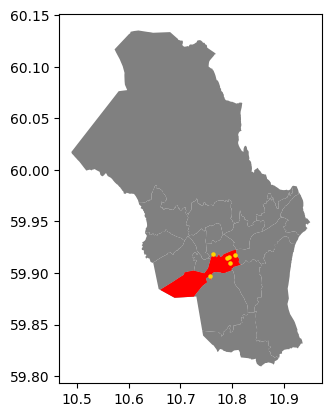

In [17]:
akser = bydeler.plot(facecolor="grey")
gamle_oslo.plot(ax=akser, facecolor="red")

adresser_i_gamle_oslo.plot(
    ax=akser,
    color="gold",
    markersize=5
)

Perfekt! Nå sitter vi igjen med bare de (gyldne) punktene som faktisk er
inne i det røde polygonet. Det er akkurat det vi ønsket!